In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# K Means Cluster - Neural Network Embeddings
Cluster the NAICS embeddings from the Neural Network.  Compare this clustering to the default NAICS code clusters on these embeddings

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
from pathlib import Path

In [5]:
import sklearn as sk
from sklearn.cluster import KMeans

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import importlib

In [8]:
from sba_gnn.sba_gnn import sg_plot, sg_embed

In [9]:
sg_plot.plot_defaults()

## Import Data

##### Embeddings

In [10]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('12_DATA_embeddings.parquet')) 

In [11]:
emb_feat = [c for c in embed_df.columns if c.startswith('emb_')]

##### Loans data - get one hot length

In [12]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [13]:
one_hot_feat= [c for c in sba_loans.columns if c.startswith('NS__')]
one_hot_feat_len = len(one_hot_feat)
one_hot_feat_len

10

## NAICS mappings
Import the map, and flag the ones selected by OneHotEncoder in script 01.  Also add in train counts, standard mean encodings, and raw means

In [14]:
naics_map = pd.read_csv('naics/naics_map.csv', dtype='str', encoding='latin1' ) \
    .rename(columns={'Sector': 'NAICS_sector',
                     'Description': 'NAICS_sector_desc'})

In [15]:
one_hot_cat = [c.split('___')[-1] for c in one_hot_feat]
one_hot_cat

['Accommodation and Food Services',
 'Administrative and Support and Waste Management and Remediation Services',
 'Construction',
 'Health Care and Social Assistance',
 'Manufacturing',
 'Other Services (except Public Administration)',
 'Professional, Scientific, and Technical Services',
 'Retail Trade',
 'Wholesale Trade',
 'infrequent_sklearn']

In [16]:
naics_map['NAICS_sector_sel'] = np.where(naics_map['NAICS_sector_desc'].isin(one_hot_cat), 1, 0)
naics_map.drop_duplicates('NAICS_sector')['NAICS_sector_sel'].value_counts()
naics_map['NAICS_sector_comb'] = naics_map['NAICS_sector'] + ':' + naics_map['NAICS_sector_desc'].str[0:20]

In [17]:
naics_map.head(5)

,NAICS_sector,NAICS_2,NAICS_sector_desc,NAICS_sector_sel,NAICS_sector_comb
0,11,11,"Agriculture, Forestry, Fishing and Hunting",0,"11:Agriculture, Forestr"
1,21,21,"Mining, Quarrying, and Oil and Gas Extraction",0,"21:Mining, Quarrying, a"
2,22,22,Utilities,0,22:Utilities
3,23,23,Construction,1,23:Construction
4,31-33,31,Manufacturing,1,31-33:Manufacturing


In [18]:
naics_map.to_parquet(Path(setup.temp_path).joinpath('60_DATA_naics_map.parquet')) 

##### Get NAICS info
Include train data count and rates, as well as mean and count encodings

In [19]:
naics_info_1 = sba_loans[sba_loans['dset'] == 'train'] \
    .groupby('NAICS') \
    ['target'] \
    .agg(['count', 'mean']) \
    .set_axis(['train_count', 'train_target_mean'], axis=1) \
    .reset_index()

In [20]:
naics_info_2 = sba_loans\
    .groupby('NAICS') \
    [['NAICS_sector', 'menc_NAICS', 'cenc_NAICS', 'dset_naics_holdout']] \
    .agg('first') \
    .reset_index()

In [21]:
naics_info_3 = sba_loans \
    .groupby('NAICS') \
    ['target'] \
    .agg(['count', 'mean']) \
    .set_axis(['all_count', 'all_target_mean'], axis=1) \
    .reset_index()

In [22]:
naics_info = naics_info_1.merge(naics_info_2, on='NAICS', how='right') \
    .merge(naics_info_3, on='NAICS', how='right') \
    .merge(naics_map[['NAICS_sector', 'NAICS_sector_sel']].drop_duplicates('NAICS_sector'), on='NAICS_sector', how='left')
naics_info['train_count'] = naics_info['train_count'].fillna(0)

In [23]:
naics_info.sample(3)

,NAICS,train_count,train_target_mean,NAICS_sector,menc_NAICS,cenc_NAICS,dset_naics_holdout,all_count,all_target_mean,NAICS_sector_sel
393,327993,10.0,0.000000,31-33,0.000000,0.000023,0,21,0.047619,1
2,111130,1.0,0.000000,11,0.204654,0.000002,0,1,0.000000,0
814,446120,1233.0,0.413625,44-45,0.413967,0.002827,0,1712,0.406542,1


In [24]:
naics_info['all_count'].describe()

count     1311.000000
mean       524.852021
std       1491.666049
min          1.000000
25%         35.000000
50%        124.000000
75%        369.500000
max      27941.000000
Name: all_count, dtype: float64

In [25]:
naics_info.to_parquet(Path(setup.temp_path).joinpath('60_DATA_naics_summary_stats.parquet')) 

## Get TSNE Values

In [26]:
tsne_df = pd.concat([sg_embed.emb_tsne_transform(embed_df[emb_feat]), embed_df['NAICS_orig']], axis=1)

## NAICS Sector "Clusters"
Get the silhouette score for the base naics

##### Merge NAICS info into embeddings

In [27]:
embed_df['NAICS_2'] = embed_df['NAICS_orig'].str[0:2]
embed_df = embed_df.drop(columns=['NAICS_sector', 'NAICS_sector_sel',
                                  'NAICS_sector_desc', 'NAICS_sector_comb', 'train_count'], 
                         errors='ignore') \
    .merge(naics_map[['NAICS_2', 'NAICS_sector', 'NAICS_sector_sel', 'NAICS_sector_desc', 'NAICS_sector_comb']], how='left') \
    .merge(naics_info.rename(columns={'NAICS':'NAICS_orig'})[['NAICS_orig', 'train_count']],
           on='NAICS_orig', how='left')

In [28]:
embed_df['NAICS_sector_filt'] = np.where(embed_df['NAICS_sector_sel'] == 0, 'Other',
                                         embed_df['NAICS_sector_comb'])
embed_df['NAICS_sector_filt'] = embed_df['NAICS_sector_filt'].astype('category')

In [29]:
embed_df['NAICS_sector_comb'] = embed_df['NAICS_sector_comb'].astype('category')

In [30]:
embed_train_df = embed_df[embed_df['train_count'] > 0]

In [31]:
tsne_df = tsne_df.drop(columns=['all_target_mean', 'menc_NAICS'], errors='ignore') \
    .merge(naics_info.rename(columns={'NAICS':'NAICS_orig'}) \
                                [['NAICS_orig', 'all_target_mean', 'menc_NAICS']],
                              how='left', on='NAICS_orig')

In [32]:
tsne_train_df = tsne_df[tsne_df['NAICS_orig'].isin(embed_train_df['NAICS_orig'])]

In [33]:
naics_silhouette = silhouette_score(embed_df[emb_feat], embed_df['NAICS_sector_comb'])
naics_silhouette_values = silhouette_samples(embed_df[emb_feat], embed_df['NAICS_sector_comb'])

In [34]:
naics_silhouette

-0.17870234

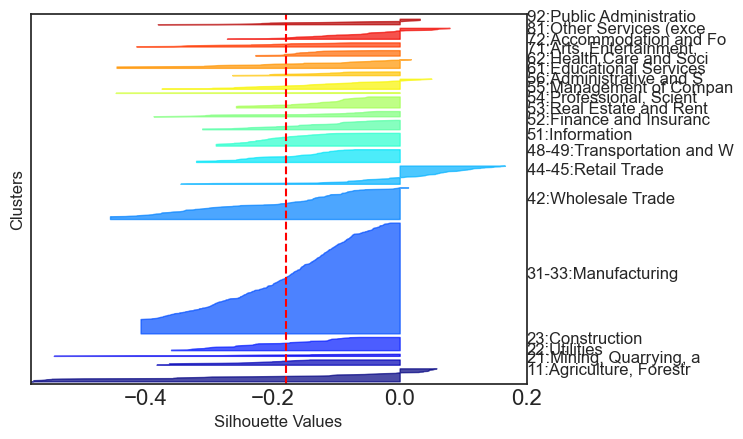

In [35]:
sg_embed.plot_silhouette(naics_silhouette_values, embed_df['NAICS_sector_comb'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_silhouette_base_naics_all.png'),
                 bbox_inches='tight') 

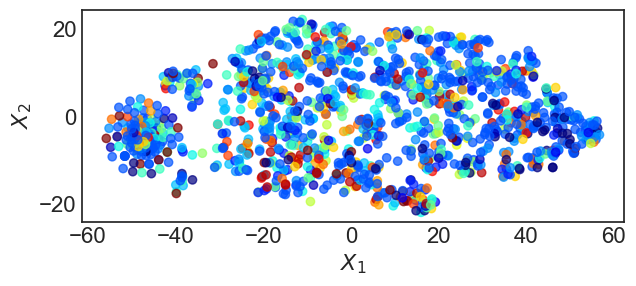

In [36]:
sg_embed.plot_clusters(tsne_df, embed_df['NAICS_sector_comb'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_base_naics_all.png'),
                 bbox_inches='tight') 

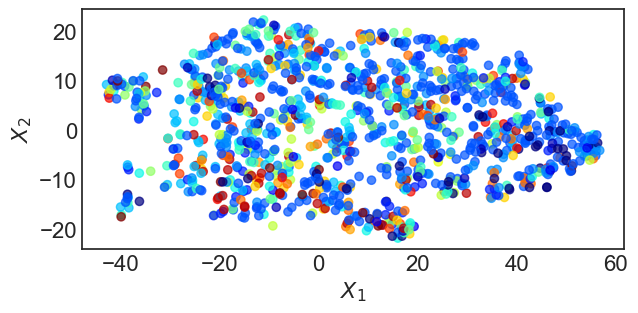

In [37]:
# Plot only on train data
sg_embed.plot_clusters(tsne_train_df, embed_train_df['NAICS_sector_comb'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_base_naics_train.png'),
                 bbox_inches='tight') 

## NAICS Sectors - Used in One Hot Only
Get the silhouette scores for the NAICS groups used in the one hot encoder (top 8 levels plus "other")

In [38]:
naics_silhouette_sel = silhouette_score(embed_df[emb_feat], embed_df['NAICS_sector_filt'])
naics_silhouette_values_sel = silhouette_samples(embed_df[emb_feat], embed_df['NAICS_sector_filt'])

In [39]:
naics_silhouette_sel

-0.16762406

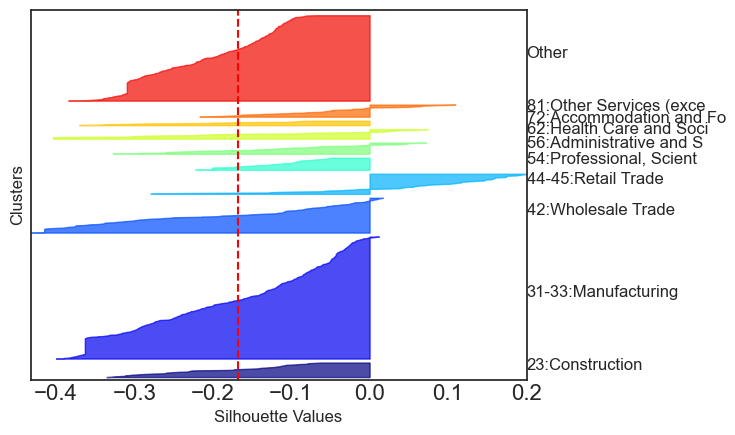

In [40]:
sg_embed.plot_silhouette(naics_silhouette_values_sel, embed_df['NAICS_sector_filt'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_silhouette_base_naics_sel.png'),
                 bbox_inches='tight') 

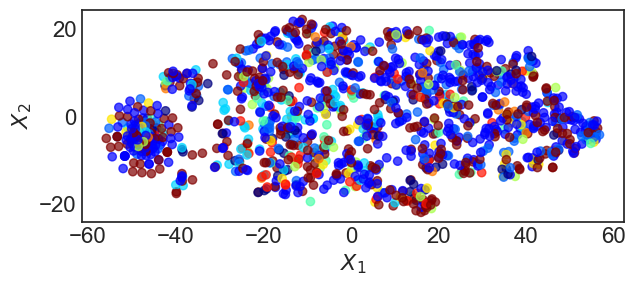

In [41]:
sg_embed.plot_clusters(tsne_df, embed_df['NAICS_sector_filt'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_base_naics_sel.png'),
                 bbox_inches='tight') 

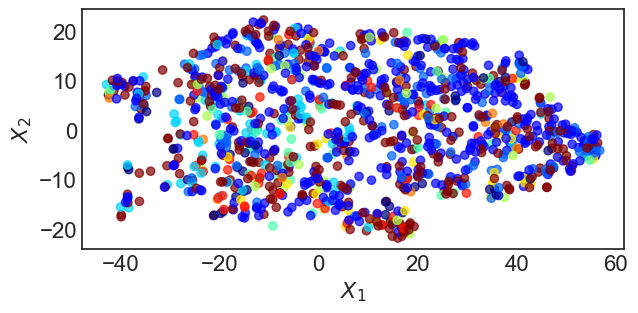

In [42]:
# Plot only on train data
sg_embed.plot_clusters(tsne_train_df, embed_train_df['NAICS_sector_filt'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_base_naics_sel_train.png'),
                 bbox_inches='tight') 

##### Save the silhouette scores

In [43]:
naics_silhouette_df = pd.DataFrame({'type':['all', 'sel'], 
                                    'score':[naics_silhouette, naics_silhouette_sel]})
naics_silhouette_df.to_csv(Path(setup.temp_path).joinpath('60_REPORT_naics_silhouette_mean.csv'))
naics_silhouette_df

,type,score
0,all,-0.178702
1,sel,-0.167624


## TSNE Plots By Target Rate

In [44]:
tsne_df.head()

,0,1,NAICS_orig,all_target_mean,menc_NAICS
0,5.767380,-5.265588,722410,0.142825,0.141777
1,41.371677,-11.384403,332721,0.059633,0.064935
2,-46.039047,-2.215373,445299,0.287306,0.204655
3,-12.536027,13.187258,441120,0.240735,0.245432
4,-45.024178,-1.943227,512110,0.190087,0.204655


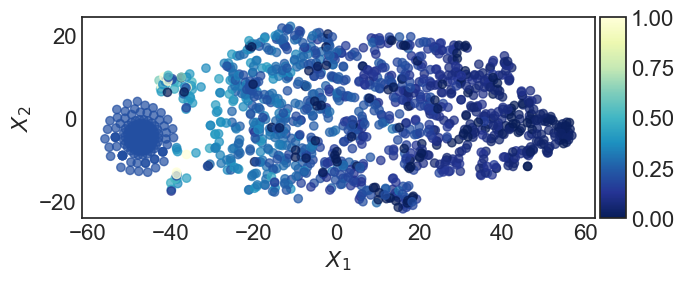

In [45]:
sg_embed.plot_clusters(tsne_df, tsne_df['menc_NAICS'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), colorbar = True)
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_naics_menc.png'),
                bbox_inches='tight') 

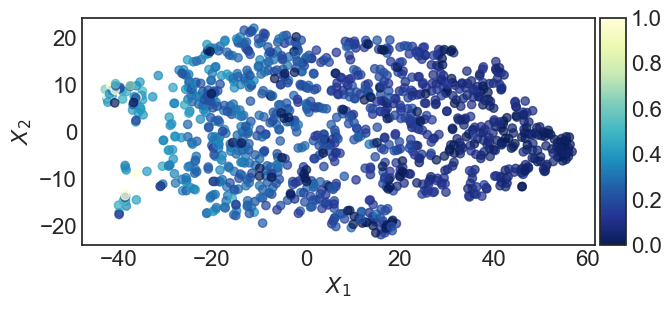

In [46]:
# train only
sg_embed.plot_clusters(tsne_train_df, tsne_train_df['menc_NAICS'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), colorbar = True)
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_naics_menc_train.png'),
                bbox_inches='tight') 

In [47]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

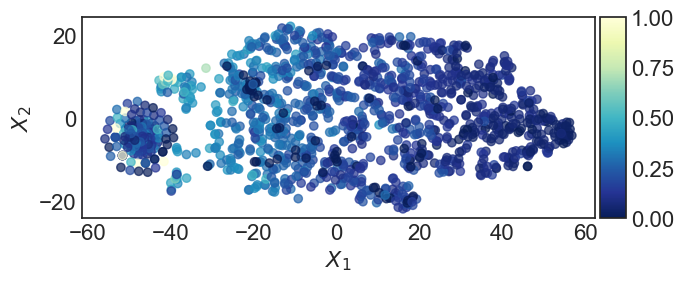

In [48]:
sg_embed.plot_clusters(tsne_df, tsne_df['all_target_mean'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), 
                       colorbar = True, aspect='equal')
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_naics_mean.png'),
                 bbox_inches='tight') 

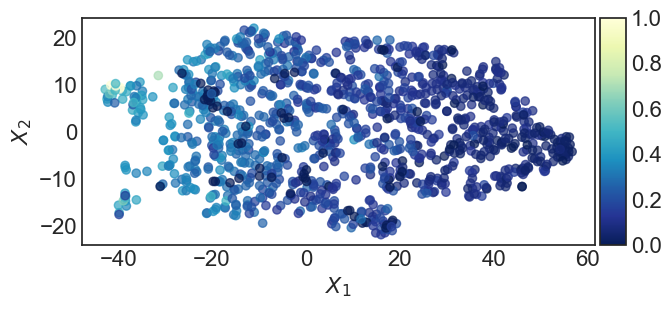

In [49]:
# Train only
sg_embed.plot_clusters(tsne_train_df, tsne_train_df['all_target_mean'],
                      center_label=False, cmap=plt.get_cmap('YlGnBu_r'), 
                       colorbar = True, aspect='equal')
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_naics_mean.png'),
                 bbox_inches='tight') 

## K Means Loop
Get silhouette scores and cluster info for a variety of counts.  Plot the best score, as well as the selected size.  Use the traiing data only

In [50]:
range_n_clusters = np.arange(2, 25)

In [51]:
all_silhouette_summary = pd.DataFrame()
all_cluster_labels = pd.DataFrame()
all_cluster_centers = pd.DataFrame()
all_silhouette_values = pd.DataFrame()

for n_clusters in range_n_clusters:
    
    # Get the kmeans information
    cluster_labels, cluster_centers, silhouette_avg, sample_silhouette_values = \
        sg_embed.get_clusters_silhouettes(embed_train_df[emb_feat], n_clusters)
        
    # Save silhouette summary
    all_silhouette_summary = pd.concat([all_silhouette_summary, 
                                        pd.DataFrame({'n_clusters': [n_clusters],
                                                      'silhouette_avg':[silhouette_avg]})])
    
    # Save silhouette values
    sample_silhouette_df = pd.DataFrame(sample_silhouette_values, columns=['value'],
                                       index = embed_train_df.index)
    sample_silhouette_df['n_clusters'] = n_clusters
    sample_silhouette_df.set_index('n_clusters', append=True,  inplace=True)
    all_silhouette_values = pd.concat([all_silhouette_values, sample_silhouette_df])
    
    # Save cluster labels
    cluster_df = pd.DataFrame(cluster_labels, columns=['label'], index=embed_train_df.index)
    cluster_df['n_clusters'] = n_clusters
    cluster_df.set_index('n_clusters', append=True,  inplace=True)
    all_cluster_labels = pd.concat([all_cluster_labels, cluster_df])
    
    # Save cluster centers
    cluster_centers_df = pd.DataFrame(cluster_centers)
    cluster_centers_df['n_clusters'] = n_clusters
    cluster_centers_df.set_index('n_clusters', append=True, inplace=True)
    all_cluster_centers = pd.concat([all_cluster_centers, cluster_centers_df])

In [52]:
all_silhouette_values.reset_index(level=1, inplace=True)
all_cluster_labels.reset_index(level=1, inplace=True)
all_cluster_centers.reset_index(level=1, inplace=True)

In [53]:
all_silhouette_values.to_parquet(Path(setup.temp_path).joinpath('60_DATA_loop_silhouette_values.parquet'))
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('60_DATA_loop_silhouette_summary.csv'))

In [54]:
all_cluster_labels.to_parquet(Path(setup.temp_path).joinpath('60_DATA_loop_cluster_labels.parquet'))

In [55]:
all_cluster_centers.columns = [str(c) for c in all_cluster_centers.columns]
all_cluster_centers.to_parquet(Path(setup.temp_path).joinpath('60_DATA_loop_cluster_centers.parquet'))

##### Get the clusters with the best silhouette score

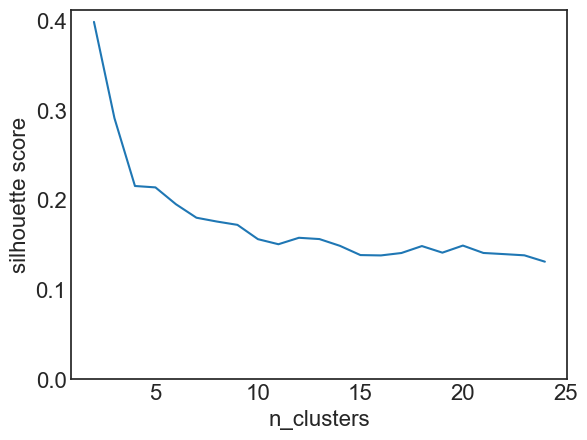

In [56]:
all_silhouette_summary.plot(x='n_clusters', y='silhouette_avg', legend=None)
plt.ylim(bottom=0)
plt.ylabel('silhouette score')
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_silhouette_summary.png'),
                 bbox_inches='tight') 
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('60_REPORT_loop_silhouette_summary.csv'))

In [57]:
best_clus = all_silhouette_summary.sort_values('silhouette_avg', ascending=False)['n_clusters'].iloc[0]
best_clus

2

## Plots for Best Score Clusters

In [58]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [59]:
best_values = all_silhouette_values[all_silhouette_values['n_clusters'] == best_clus] \
    .drop(columns='n_clusters')
best_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == best_clus] \
     .drop(columns='n_clusters')  

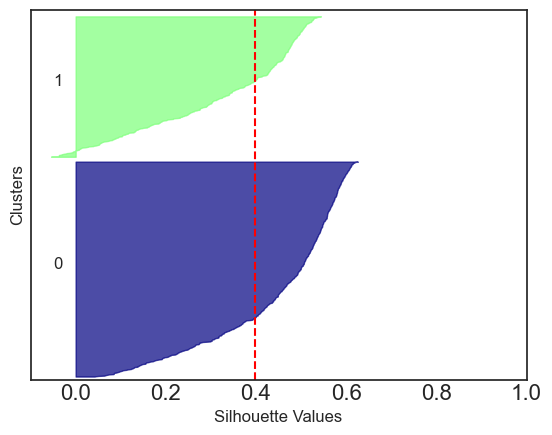

In [60]:
sg_embed.plot_silhouette(best_values.to_numpy(), best_labels.to_numpy(),
                        cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_silhouette_best.png'),
                 bbox_inches='tight') 

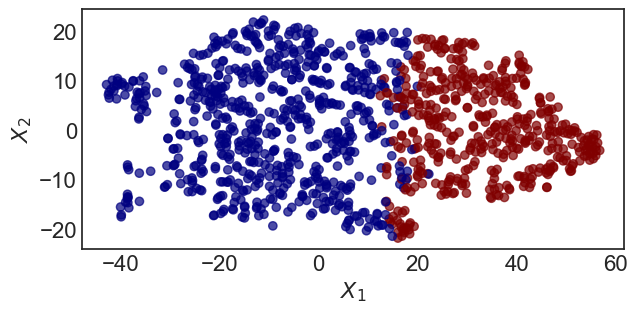

In [61]:
sg_embed.plot_clusters(tsne_train_df, best_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_clusters_best.png'),
                 bbox_inches='tight') 

## Plots for Selected Length
Use the same number of levels as we have from the original one hot encoding. Subtract 1 for "unknown"

In [62]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [63]:
sel_values = all_silhouette_values[all_silhouette_values['n_clusters'] == one_hot_feat_len  - 1] \
    .drop(columns='n_clusters')
sel_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == one_hot_feat_len - 1] \
     .drop(columns='n_clusters')  

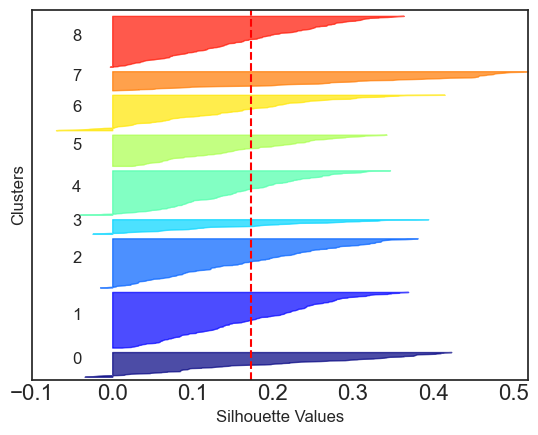

In [64]:
sg_embed.plot_silhouette(sel_values.to_numpy(), sel_labels.to_numpy(),
                        cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_silhouette_selected.png'),
                 bbox_inches='tight') 

In [65]:
np.max(sel_values.to_numpy())

0.5182122

In [66]:
np.mean(sel_values.to_numpy())

0.1724486

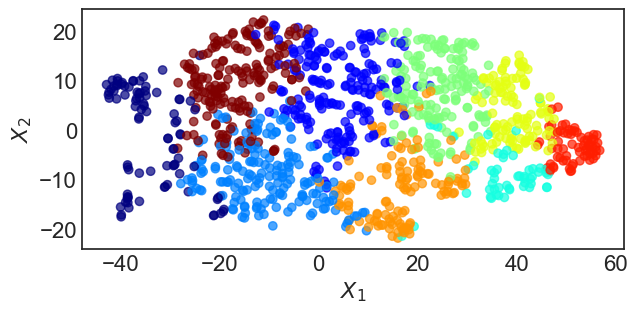

In [67]:
sg_embed.plot_clusters(tsne_train_df, sel_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_clusters_selected.png'),
                 bbox_inches='tight') 

## Save the embeddings with TSNE and Cluster Info
Include one hot encodings

In [68]:
embed_fin_df = pd.concat([embed_df.drop(columns=['tsne_0', 'tsne_1', 'NAICS_orig', 'cluster'], errors='ignore'),
                      tsne_df.rename(columns={0:'tsne_0', 1:'tsne_1'}),
                     sel_labels.rename(columns={'label':'cluster'})], axis=1)

In [69]:
embed_fin_df = pd.concat([embed_fin_df, 
                           pd.get_dummies(embed_fin_df['cluster'],prefix='NC_', dtype='int')],
                         axis=1)

In [70]:
embed_fin_df.to_parquet(Path(setup.temp_path).joinpath('60_DATA_embeddings_tsne_naics.parquet'))